# Census Folium Tutorial

## Kenneth Burchfiel

Released under the MIT license

This tutorial demonstrates how to use the functions in census_folium_viewer.py to generate interactive zip-, county-, and state-level choropleth maps based on census data and shapefiles from the US Census Bureau. Within the tutorial, I will generate maps of two data types: (1) median household income and (2) the percentage of households that consist of a married couple with at least one child below the age of 18.

The tutorial also demonstrates how to incorporate a custom vertical legend into Folium maps. These have advantages over the default horizontal legend in certain circumstances.

**Note**: Some files in this project (such as the zip-code-level HTML maps) were too large to upload to GitHub. You can instead access those files via the following Google Drive folder: https://drive.google.com/drive/folders/11h1jnaVOA5A6ubbOJnC-kPEvdnJU00yv?usp=sharing


Citation info for color_schemes_from_branca.json:

Source: https://github.com/python-visualization/branca/blob/master/branca/_schemes.json

I believe these schemes were originally created by Cynthia Brewer, and are licensed under the Apache License, Version 2.0. See http://www.personal.psu.edu/cab38/ColorBrewer/ColorBrewer_updates.html

## Preliminary steps

First, you'll need to download zip code, county, and state shapefiles from the US Census bureau: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

I used 2020 zip code shapefiles for this project, which are available here: https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=ZIP+Code+Tabulation+Areas

See this note regarding use of the shapefiles: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2021/TGRSHP2021_TechDoc_Ch1.pdf

Once you download the shapefiles to your computer, extract them using an unzipping utility. The shapefile document within this unzipped folder ends in .shp; for the 2020 zip code data, the file name is tl_2020_us_zcta520.shp. 

It appears that the other files within this folder may also be used by Geopandas in the creation of GeoDataFrames, so I recommend accessing the file within the unzipped folder rather than copying it into your project folder.

This project already contains zip-, county-, and state-level American Community Survey data (5-year estimates) for various demographic variables. I created these data files via my Census query tutorial available at https://github.com/kburchfiel/census_query_tutorial . 


In [1]:
import time
start_time = time.time()
import census_folium_viewer
import geopandas
import numpy as np
import pandas as pd
import folium

## Part 1: Zip Code-Level Maps

The following code block uses census_folium_viewer.py's prepare_zip_table() function to create a GeoDataFrame storing both zip code and census data. It took 126.6 seconds for the function to create a table, whereas importing a saved version of this file took only 8.9 seconds. Therefore, to save time, I edited the code block so that it would only regenerate the GeoDataFrame if instructed to do so.

I recommend reading the documentation in census_folium_viewer.py for prepare_zip_table so that you'll better understand the inputs used by this function.

The zip code census data file only includes zip codes with at least 1,000 households, preventing outliers in the data related to low sample sizes.

In [2]:
create_new_zip_census_table = False

if create_new_zip_census_table == True:

    zip_and_census_table = census_folium_viewer.prepare_zip_table(
        shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_zcta520\tl_2020_us_zcta520.shp',
        shape_feature_name = 'ZCTA5CE20', tolerance = 0.005, data_path =
        'acs5_2019_zip_results_1k_plus_households.csv',
        data_feature_name = 'NAME')
    print("Exporting data:")
    zip_and_census_table.to_file('zip_and_census_table.geojson',
    driver = 'GeoJSON') 
    # The above line exports the GeoDataFrame created by prepare_zip_table 
    # so that it can be imported back into the program, which takes less time
    # than does recreating the GeoDataFrame.

After being stored within the project folder, this table gets re-read into Python. That way, the program will still function even if create_new_zip_census_table was set to false.

In [3]:
zip_and_census_table = geopandas.read_file('zip_and_census_table.geojson')

First, I will create a map displaying median household income by zip code. (Note: I will exclude Puerto Rico from these maps so as to focus on the 50 US states and DC. Puerto Rico has the code 72 in the 'state' column of the merged zip code data table, hence the use of zip_and_census_table.query("state != 72") as the argument for the merged_data_table parameter.)

If you haven't done so already, I highly recommend reading the documentation for generate_map so that you'll know what inputs are necessary for the function to run correctly.

In [4]:
zip_and_census_table

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Unnamed: 0,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,16220,...,0.000000,0.482143,0.100000,0.698795,0.000000,0.181904,0.399937,0.267672,0.150487,"POLYGON ((-88.24735 33.65390, -88.23926 33.677..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,16222,...,0.000000,0.130435,0.325581,0.119403,0.000000,0.217328,0.377139,0.283582,0.121951,"POLYGON ((-88.13997 34.58184, -88.10945 34.797..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,15468,...,0.000000,0.000000,0.245902,1.000000,0.000000,0.196456,0.349140,0.290776,0.163627,"POLYGON ((-86.81659 34.34960, -86.78459 34.361..."
3,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,16397,...,0.006024,0.444444,0.371134,0.509804,0.238095,0.235059,0.411892,0.215034,0.138016,"POLYGON ((-85.95712 31.67744, -85.91199 31.669..."
4,36064,36064,B5,G6350,S,222734779,2634627,+32.3041726,-086.0899193,14374,...,0.008403,0.000000,0.000000,0.756757,0.000000,0.043204,0.127363,0.217072,0.612361,"POLYGON ((-86.20453 32.28616, -86.17882 32.286..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16976,78589,78589,B5,G6350,S,66019928,203939,+26.1511510,-098.1593071,7984,...,0.082742,0.525870,0.618585,0.355491,0.252874,0.386049,0.260084,0.224263,0.129604,"POLYGON ((-98.20340 26.07032, -98.20061 26.085..."
16977,79226,79226,B5,G6350,S,2114223394,16828257,+34.9183363,-100.9970867,6843,...,0.000000,0.185185,0.627907,0.176471,0.272727,0.107989,0.352066,0.364738,0.175207,"POLYGON ((-101.32895 35.17773, -101.18226 35.1..."
16978,78957,78957,B5,G6350,S,458557393,5334310,+30.0138808,-097.1820983,7459,...,0.004545,0.055556,0.303867,0.101351,0.000000,0.129181,0.311580,0.295971,0.263267,"POLYGON ((-97.34296 29.97311, -97.33280 29.992..."
16979,78962,78962,B5,G6350,S,446486715,1109498,+29.6744394,-096.7344998,7460,...,0.000000,0.000000,0.114286,0.000000,0.000000,0.135564,0.345255,0.293049,0.226132,"POLYGON ((-96.85474 29.65895, -96.85038 29.678..."


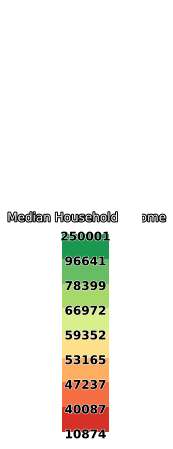

In [5]:
zip_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("state != 72 & Median_household_income >= 0"),
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Median_household_income", feature_text = 'Zip Code',
    data_variable_text = 'Median Household Income',
    popup_variable_text = 'Income', 
    variable_decimals = None,
    map_name = 'zip_median_hh_income',
    fill_color = 'RdYlGn',
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 1, 
    vertical_legend = True)


In [6]:
# zip_median_hh_income_map

Next, I'll create a map showing the proportion of households in each zip code in the dataset that consist of a married couple with at least one child.

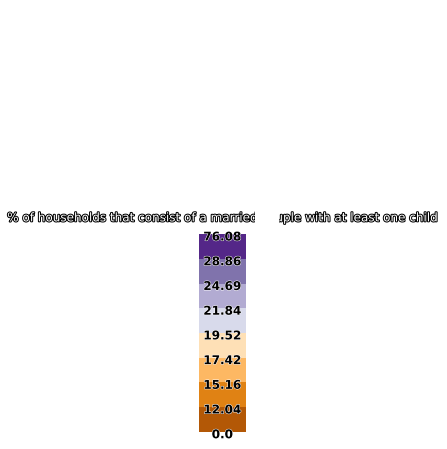

In [7]:
zip_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = zip_and_census_table.query("state != 72"),
    shape_feature_name = 'ZCTA5CE20',
    data_variable = "Married_couple_households_with_one_or_more_children_as_proportion_of_all_households",
    feature_text = 'Zip Code',
    data_variable_text= '% of households that consist of a married couple \
with at least one child',
    popup_variable_text = 'Percentage', 
    map_name = 'zip_married_couples_with_kids', fill_color = 'PuOr', 
    bin_count = 8,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    bin_type = 'percentiles', rows_to_map = 0, multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

In [8]:
# zip_married_couples_with_children_map

## Part 2: County-Level Maps

The steps for generating county-level maps are similar. Note that the county census data file being imported only contains counties with at least 1,000 households.

In [9]:
county_and_census_table = census_folium_viewer.prepare_county_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2021_us_county\tl_2021_us_county.shp',
    shape_state_code_column = 'STATEFP', shape_county_code_column = 'COUNTYFP',
    tolerance = 0.005,
    data_path = 'acs5_2019_county_results_1k_plus_households.csv',
    data_state_code_column = 'state', data_county_code_column = 'county')
print("Exporting data:")
county_and_census_table.to_file('county_and_census_table.geojson',
    driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
county_and_census_table

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME_x,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher
0,31,39,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,...,0.034328,0.000000,0.000000,0.166667,0.186441,0.487805,0.116386,0.350643,0.295087,0.237883
1,53,69,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,...,0.055249,0.054902,0.000000,0.116279,0.303030,0.000000,0.078883,0.300364,0.426881,0.193871
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,0.037271,0.016040,0.447822,0.265576,0.286342,0.118361,0.063232,0.215346,0.326237,0.395184
3,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,...,0.046322,0.046610,0.136364,0.179487,0.200000,0.000000,0.080755,0.340280,0.369586,0.209378
4,72,85,01804523,72085,Las Piedras,Las Piedras Municipio,13,H1,G4020,490,...,0.161747,0.077246,0.564315,0.696013,0.650388,0.413043,0.221642,0.243033,0.311601,0.223724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,...,0.048333,0.033314,0.762712,0.290419,0.121827,0.000000,0.182797,0.354023,0.258723,0.204458
3082,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,...,0.027839,0.021158,0.400000,0.403361,0.180723,0.000000,0.070555,0.351141,0.375493,0.202811
3083,28,89,00695768,28089,Madison,Madison County,06,H1,G4020,298,...,0.019584,0.008020,0.338462,0.389878,0.254167,0.119063,0.082589,0.169971,0.263334,0.484106
3084,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,...,0.027956,0.023102,0.533333,0.307065,0.410663,0.000000,0.200154,0.336843,0.336762,0.126240


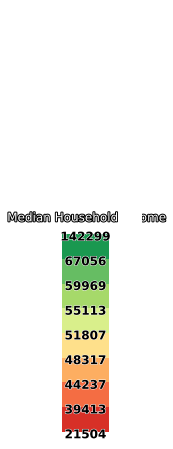

In [11]:
county_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72 & Median_household_income >= 0"), 
    shape_feature_name = 'NAME_y', # NAME_y is the copy of the 'NAME' column
    # from the data table. It contains both county and state names.
    data_variable = 'Median_household_income', feature_text = 'County',
    data_variable_text = 'Median Household Income',
    map_name = 'county_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots',
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 1, 
    vertical_legend = True)

# county_hh_income_map

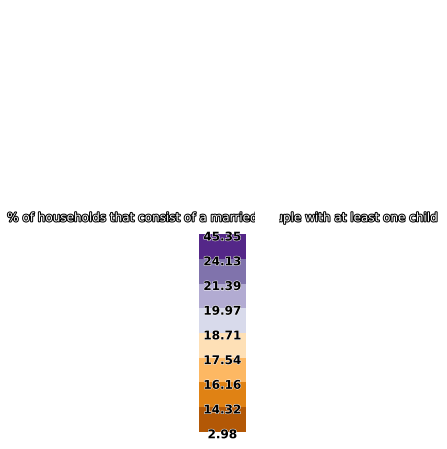

In [12]:
county_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = county_and_census_table.query("state != 72"),
    shape_feature_name = 'NAME_y',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households',
    feature_text = 'County', data_variable_text = '% of households \
that consist of a married couple with at least one child', 
    map_name = 'county_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', bin_count = 8,
    rows_to_map = 0, bin_type = 'percentiles', multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

# county_married_couples_with_children_map

# Part 3: State-Level Maps

Finally, I'll create state-level maps of median household income and married-couple family prevalence.

In [13]:
state_and_census_table = census_folium_viewer.prepare_state_table(
    shapefile_path = r'C:\Users\kburc\Downloads\tl_2020_us_state\tl_2020_us_state.shp', 
    shape_feature_name = 'NAME', tolerance = 0.005, data_path = 
    'acs5_2019_state_results.csv', data_feature_name = 'NAME')
print("Exporting data:")
state_and_census_table.to_file('state_and_census_table.geojson',
driver = 'GeoJSON') 

Reading shape data:
Simplifying shape data:
Reading census data:
Merging shape and data tables:
Exporting data:


C:\Users\kburc\miniforge3\envs\ga15pyd\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [14]:
state_and_census_table

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,...,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_married-couple_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_female-householder_families_below_the_poverty_level_where_householder_did_not_graduate_high_school,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_high_school_graduate/equivalent,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_=_some_college_or_associate's_degree,Proportion_of_female-householder_families_below_the_poverty_level_where_householder's_highest_education_level_=_bachelor's_degree_or_higher,Proportion_of_individuals_25+y/o_who_did_not_graduate_high_school,Proportion_of_individuals_25+y/o_whose_highest_education_level_=_high_school_graduate/equivalent,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_some_college/associate's_degree,Proportion_of_individuals_25+_y/o_whose_highest_education_level_=_bachelor's_degree_or_higher
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,...,0.055894,0.017533,0.453365,0.392072,0.370437,0.091641,0.130978,0.403200,0.259676,0.206146
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,...,0.047571,0.029266,0.410075,0.295617,0.219937,0.109616,0.118109,0.285735,0.297361,0.298796
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,...,0.033824,0.016472,0.420266,0.323068,0.259687,0.090065,0.107876,0.259549,0.286049,0.346526
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,...,0.023636,0.010725,0.476110,0.267032,0.212990,0.077315,0.068595,0.246476,0.324111,0.360818
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,...,0.023519,0.013103,0.362341,0.238542,0.161790,0.056966,0.097961,0.246110,0.254208,0.401720
5,1,1,44,01219835,44,RI,Rhode Island,00,G4000,A,...,0.030438,0.014384,0.429792,0.291110,0.227019,0.104102,0.111865,0.282674,0.263467,0.341994
6,4,8,16,01779783,16,ID,Idaho,00,G4000,A,...,0.060987,0.025840,0.435167,0.340307,0.275732,0.144987,0.092267,0.273569,0.358484,0.275680
7,1,1,33,01779794,33,NH,New Hampshire,00,G4000,A,...,0.020472,0.009945,0.334631,0.234573,0.176957,0.089613,0.068940,0.274196,0.286434,0.370429
8,3,5,37,01027616,37,NC,North Carolina,00,G4000,A,...,0.042321,0.017014,0.479545,0.347018,0.284973,0.102653,0.122195,0.256525,0.308723,0.312557
9,1,1,50,01779802,50,VT,Vermont,00,G4000,A,...,0.028785,0.016623,0.507655,0.298461,0.237657,0.111244,0.073278,0.287954,0.258523,0.380246


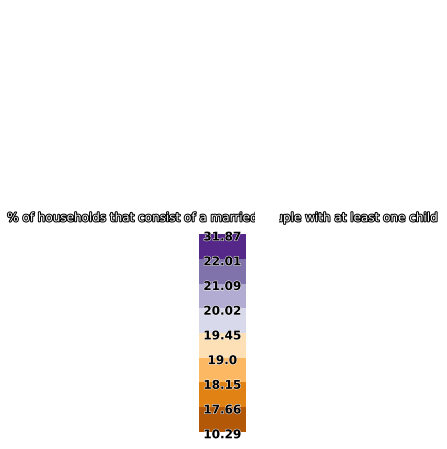

In [15]:
state_married_couples_with_children_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("NAME != 'Puerto Rico'"),
    shape_feature_name = 'NAME',
    data_variable = 'Married_couple_households_with_one_or_more_children_as_proportion_of_all_households', 
    feature_text = 'State', 
    data_variable_text = '% of households that consist of a married \
couple with at least one child', 
    map_name = 'state_married_couples_with_kids', 
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial',
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Percentage', fill_color = 'PuOr', 
    rows_to_map = 0, bin_type = 'percentiles', bin_count = 8, 
    multiply_data_by = 100,
    variable_decimals = 2, vertical_legend = True)

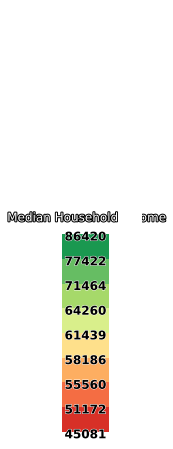

In [16]:
state_median_hh_income_map = census_folium_viewer.generate_map(
    merged_data_table = state_and_census_table.query("state != 72 & Median_household_income >= 0"), shape_feature_name = 'NAME',
    data_variable = 'Median_household_income', feature_text = 'State', 
    data_variable_text = 'Median Household Income', 
    map_name = 'state_median_hh_income', 
    variable_decimals = None,
    html_save_path = r'C:\Users\kburc\D1V1\Documents\!Dell64docs\Programming\py\kjb3_programs\census_folium_tutorial', 
    screenshot_save_path = 'census_folium_map_screenshots', 
    popup_variable_text = 'Income', fill_color = 'RdYlGn', 
    rows_to_map = 0, bin_count = 8,
    bin_type = 'percentiles', multiply_data_by = 1, vertical_legend = True, 
    generate_image = True)

In [17]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),
"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),
"second(s))") 
# Only meaningful when the program is run nonstop from start to finish

Completed run at Thu Mar 31 01:19:45 2022 (local time)
Total run time: 162.42 second(s) (2.0 minute(s) and 42.42 second(s))
